# Курсовой проект по курсу: Библиотеки Python для Data Science. Продоолжение



# Оглавление <a name='index'>

 Загрузка всего
 
**[Смотрим Пропуски](#nulls)**

**[Служебные функции](#work)**

**Обзор Данных:**

* **[Home Ownership](#1_hw)** - домовладение `dummies`
* **[Annual Income](#2_ai)** - годовой доход (**1557 пропусков**) `Заполняем пропуки при помощи Линейной регрессии` + немного обрезаем хвос (99 квантили)
* **[Years in current job](#3_yicj)** - количество лет на текущем месте работы (**371 пропуск**) `категории + пропуски в отдельную`
* **[Tax Liens](#4_tl)** - налоговые обременения **идет в новый признак**
* **[Number of Open Accounts](#5_nooa)** - количество открытых счетов `заменяем > 95 квантили меняем медиану`
* **[Years of Credit History](#6_yoch)** - количество лет кредитной истории `больше 40 меняем на 40`
* **[Maximum Open Credit](#7_moc)** - наибольший открытый кредит `заменяем > 95 квантили меняем на = 95 квант`
* **[Number of Credit Problems](#8_nocp)** - количество проблем с кредитом **идет в новый признак**
* **[Months since last delinquent](#9_msld)** - количество месяцев с последней просрочки платежа (**4071 пропуск**) `null в 0 + в отдельный столбец.`
* **[Bankruptcies](#10_b)** - банкротства (**14 пропусков**) `null в 0` + **идет в новый признак**
* **[Purpose](#11_p)** - цель кредита `в категории + объединяем категории чтобы осталось 4`
* **[Term](#12_t)** - срок кредита `в 2 категории`
* **[Current Loan Amount](#13_cla)** - текущая сумма кредита `заменяем > 95 квантили меняем среднюю` + `выбросы в отделную переменную`
* **[Current Credit Balance](#14_ccb)** - текущий кредитный баланс `заменяем > 95 квантили меняем на = 95 квант`
* **[Monthly Debt](#15_md)** - ежемесячный долг `меняем >99 проц на среднее..`
* **[Credit Score](#16_cs)** - кредитный рейтинг (**1557 пропусков**) `делим на категории + null в отделную категорию`
* **[Credit Default](#17_cd)** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка) 

**[Новый признак](#new)** - вместо `Tax Liens`, `Number of Credit Problems` и `Bankruptcies` делаю один признак, а эти исключаю

**[Смотрим, что получилось после обработки данных](#look)**

**[Нормализация данных](#norm) + Отбор данных для CatBoost** `выключено, потому-что с ним результат хуже`

**[Разбиение на train / test. Балансировка целевой переменной](#20_learn)** `с балансировкой хуже - выключено`

**[Обучение на моделях](#21_learn1)**


## Загрузка всего <a name='load'></a>

[к оглавлению](#index)

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
# Загрузка библиотек:

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve

# Алгоритмы кластеризации (какие нашел)

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Метрика F1:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# для статистики
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import probplot

In [3]:
# Загрузка наборов данных:

df = pd.read_csv('course_project_train.csv')
df_test = pd.read_csv('course_project_test.csv')

In [4]:
# Добавляем в тренировочный набор нанных поле ID

df['ID'] = df.index.tolist()

## Обзор данных <a name='view'>
    
[к оглавлению](#index)

In [5]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,ID
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,2
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,3
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,4


In [6]:
df.shape

(7500, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.00,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.00,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.00,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.50,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.50,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.00,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.00,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.00,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.00,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.50,209323.0,360406.25,6.506797e+06


## Пропуски <a name="nulls"></a>

[к оглавлению](#index)

In [9]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
ID                                 0
dtype: int64

In [10]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

## Служебные функции <a name="work"></a>

[к оглавлению](#index)

In [11]:
# функция показывает корреляцию мжду двумя группами одного признака в отношении целевого признака. 
# если результат больше 0.05 - можно объединять в один
def corr_(val, x1, x2):
    pay1_and_target_s = df.loc[df[val].isin([x1, x2]), ['ID', val, 'Credit Default']]#.sample(1000)
    table = pay1_and_target_s.pivot_table(values='ID', index=val, columns='Credit Default', aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    print(p)
    
    
# метрики в читеамом виде
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
    
def mis_values_report(df):
    '''Функция считает и выводит пропущенные значения столбцов датафрейма'''
    mis_val = df.isnull().sum()
    perc_mis_val = 100 * df.isnull().sum() / len(df)
    report = pd.concat([mis_val, perc_mis_val], axis=1)
    report_columns = report.rename(columns = {0: 'Пропущенные значения', 1: '% от всех значений'})
    report_columns = report_columns[report_columns.iloc[:,1] != 0].sort_values('% от всех значений', ascending=False).round(1)
    print('Датафрейм имеет ' + str(df.shape[1]) + ' столбцов.\n' + str(report_columns.shape[0]) + ' столбцов имеют пропущенные значения')
    return report_columns


def hist_qq(target_name):
    plt.figure(figsize=(20,8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(target_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{target_name} distribution')
    df[target_name].hist()
    plt.subplot(122)
    probplot(df[target_name],dist='norm',plot=plt)

    plt.show()
    

# # балансеровка целевой переменной
# def balance_df_by_target(df, target_name):

#     target_counts = df[target_name].value_counts()

#     major_class_name = target_counts.argmax()
#     minor_class_name = target_counts.argmin()

#     disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

#     for i in range(disbalance_coeff):
#         sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
#         df = df.append(sample, ignore_index=True)

#     return df.sample(frac=1) 

# балансеровка целевой переменной УЛУЧШЕННАЯ
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [12]:
mis_values_report(df)

Датафрейм имеет 18 столбцов.
5 столбцов имеют пропущенные значения


,Пропущенные значения,% от всех значений
Months since last delinquent,4081,54.4
Annual Income,1557,20.8
Credit Score,1557,20.8
Years in current job,371,4.9
Bankruptcies,14,0.2


# Обработка данных

### Home Ownership - домовладение <a name="1_hw"></a>

[к оглавлению](#index)

In [13]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

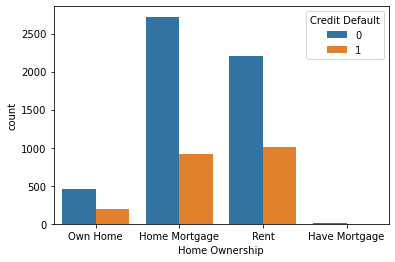

In [14]:
sns.countplot(x="Home Ownership", hue='Credit Default', data=df)
plt.show()

In [15]:
df = pd.concat([df, pd.get_dummies(df['Home Ownership'], prefix='Home Ownership')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'], prefix='Home Ownership')], axis=1)

### Annual Income - годовой доход <a name="2_ai"></a>

[к оглавлению](#index)

In [16]:
df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

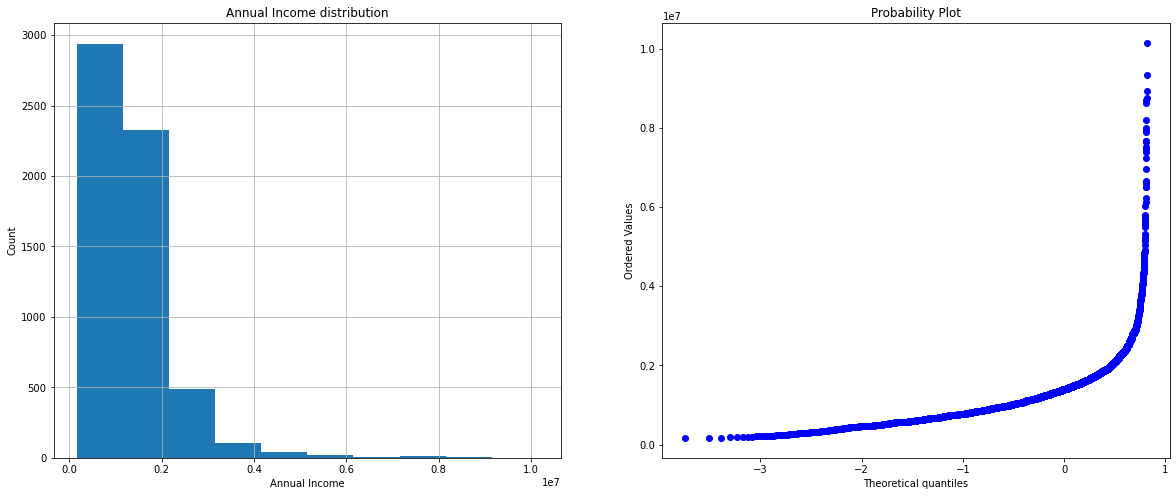

In [17]:
hist_qq('Annual Income')

In [18]:
# df.loc[df['Annual Income'].isnull(), 'Annual Income'] = 0
# df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = 0

## `Заполняем попуски и выбросы при помощи Линейной Регрессии`

In [19]:
# df.loc[(df['Annual Income'] > df['Annual Income'].quantile(.95)), :].shape

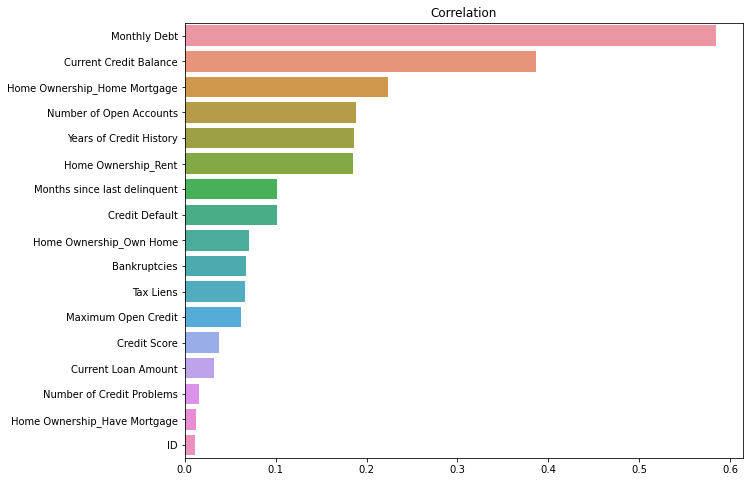

In [20]:
# смотрим, как коррелируют признаки с 'Annual Income'

FEATURE_NAMES = df.columns.drop('Annual Income').tolist()
corr_Annual_Income = df[FEATURE_NAMES + ['Annual Income']].corr().iloc[:-1, -1]
corr_Annual_Income = np.abs(corr_Annual_Income).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Annual_Income.values, y=corr_Annual_Income.index)

plt.title('Correlation')
plt.show()

In [21]:
# для обучения выбираем 7 наиболее влияющих признаков (8-й признак сам имеет много null)
TARGET_FEATURE = list(corr_Annual_Income.index[0:6])

In [22]:
# отбираем набор данных для обучения
data = df.loc[(df['Annual Income'].notnull()), TARGET_FEATURE + ['Annual Income']]#.sample(2000)
data

,Monthly Debt,Current Credit Balance,Home Ownership_Home Mortgage,Number of Open Accounts,Years of Credit History,Home Ownership_Rent,Annual Income
0,7914.0,47386.0,0,11.0,26.3,0,482087.0
1,18373.0,394972.0,0,15.0,15.3,0,1025487.0
2,13651.0,308389.0,1,11.0,35.0,0,751412.0
3,11338.0,95855.0,0,8.0,22.5,0,805068.0
4,7180.0,93309.0,0,13.0,13.6,1,776264.0
...,...,...,...,...,...,...,...
7491,61150.0,108889.0,1,18.0,21.3,0,2833185.0
7493,27562.0,167428.0,0,14.0,16.5,1,1257610.0
7495,1900.0,73492.0,0,3.0,8.5,1,402192.0
7496,12783.0,456399.0,1,10.0,26.5,0,1533984.0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Monthly Debt                  5943 non-null   float64
 1   Current Credit Balance        5943 non-null   float64
 2   Home Ownership_Home Mortgage  5943 non-null   uint8  
 3   Number of Open Accounts       5943 non-null   float64
 4   Years of Credit History       5943 non-null   float64
 5   Home Ownership_Rent           5943 non-null   uint8  
 6   Annual Income                 5943 non-null   float64
dtypes: float64(5), uint8(2)
memory usage: 290.2 KB


In [24]:
%%time

# учимся на Регрессии

model_Annual_Income = LogisticRegression()
model_Annual_Income.fit(data[TARGET_FEATURE], data['Annual Income'])

Wall time: 5min 30s


LogisticRegression()

In [25]:
# заполняем пропуски на основе обученной модели

df.loc[(df['Annual Income'].isnull()), ['Annual Income']] =\
model_Annual_Income.predict(df.loc[(df['Annual Income'].isnull()), TARGET_FEATURE])

df_test.loc[(df_test['Annual Income'].isnull()), ['Annual Income']] =\
model_Annual_Income.predict(df_test.loc[(df_test['Annual Income'].isnull()), TARGET_FEATURE])

In [26]:
# смотрим, какое распределение получилось

shapiro(df['Annual Income'])

ShapiroResult(statistic=0.754403829574585, pvalue=0.0)

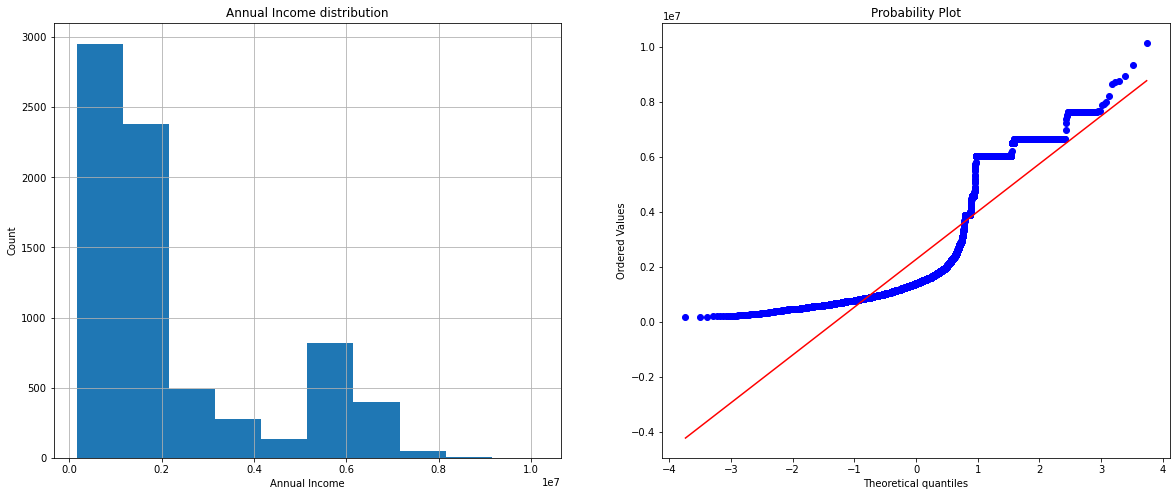

In [27]:
hist_qq('Annual Income')

In [28]:
Annual_Income_with_target_s = df[['Annual Income', 'Credit Default']]#.sample(1000)
Annual_Income_target_0 = df.loc[df['Credit Default'] == 0, ['Annual Income']]
Annual_Income_target_1 = df.loc[df['Credit Default'] == 1, ['Annual Income']]

In [29]:
mannwhitneyu(Annual_Income_target_0, Annual_Income_target_1)

MannwhitneyuResult(statistic=5486954.0, pvalue=0.007655524784304955)

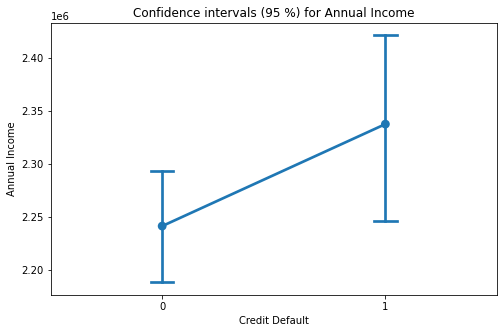

In [30]:
plt.figure(figsize=(8,5))

sns.pointplot(x='Credit Default', y='Annual Income', data=Annual_Income_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Annual Income')

plt.show()

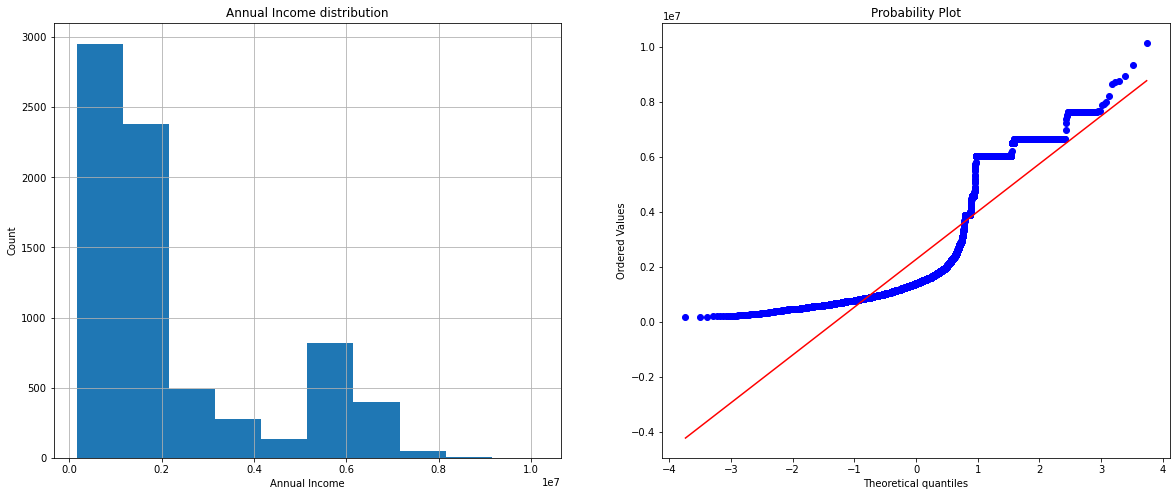

In [31]:
hist_qq('Annual Income')

In [32]:
# обрезаем хвост

df.loc[df['Annual Income'] > df['Annual Income'].quantile(.99), ['Annual Income']] =\
            df['Annual Income'].quantile(.99)  #df['Annual Income'].median()

df_test.loc[df_test['Annual Income'] > df_test['Annual Income'].quantile(.99), ['Annual Income']] = \
            df_test['Annual Income'].quantile(.99) #df_test['Annual Income'].median()

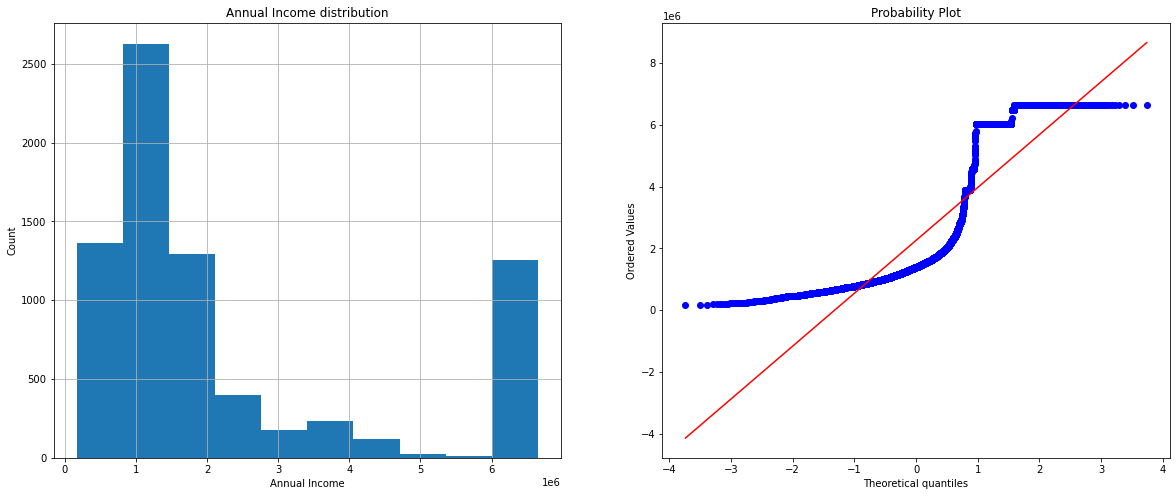

In [33]:
hist_qq('Annual Income')

### Years in current job - количество лет на текущем месте работы <a name="3_yicj"></a>

[к оглавлению](#index)

In [34]:
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

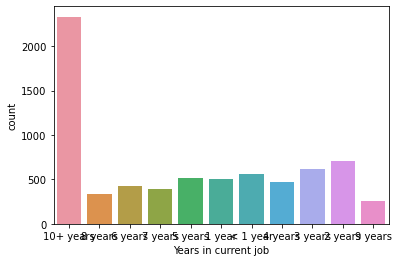

In [35]:
sns.countplot(x="Years in current job", data=df)
plt.show()

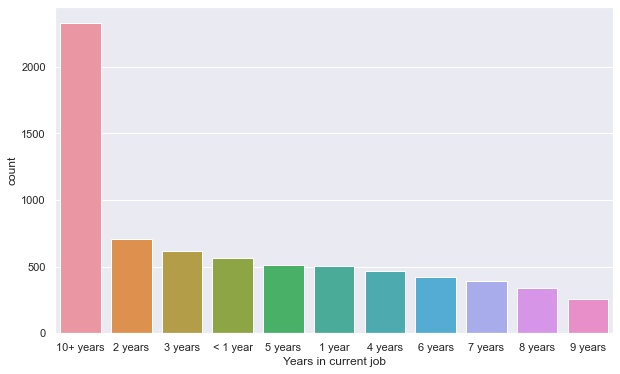

In [36]:
# посмотрим как выглядит распределение от стажа на месте
sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
sns.countplot(df['Years in current job'], order = df['Years in current job'].value_counts().index)

In [37]:
df['Years in current job'] = df['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)

df.loc[df['Years in current job'].isnull(), 'Years in current job'] = 11



df_test['Years in current job'] = df_test['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)

df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = 11

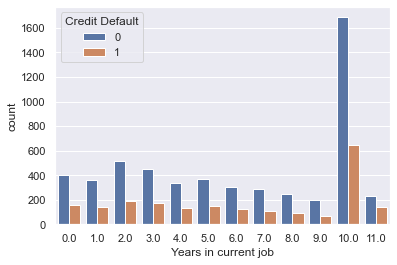

In [38]:
sns.countplot(x="Years in current job", hue='Credit Default', data=df)
plt.show()

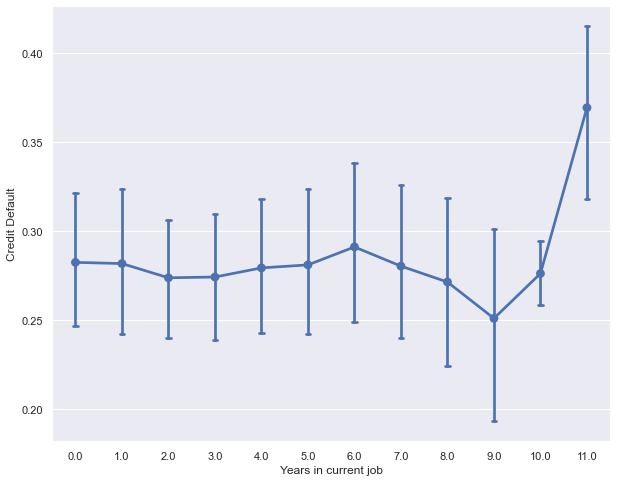

In [39]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='Years in current job', y='Credit Default', data=df, capsize=.1,);

### Tax Liens - налоговые обременения <a name="4_tl"></a>

[к оглавлению](#index)

In [40]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

### Number of Open Accounts - количество открытых счетов <a name="5_nooa"></a>

[к оглавлению](#index)

In [41]:
df['Number of Open Accounts'].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

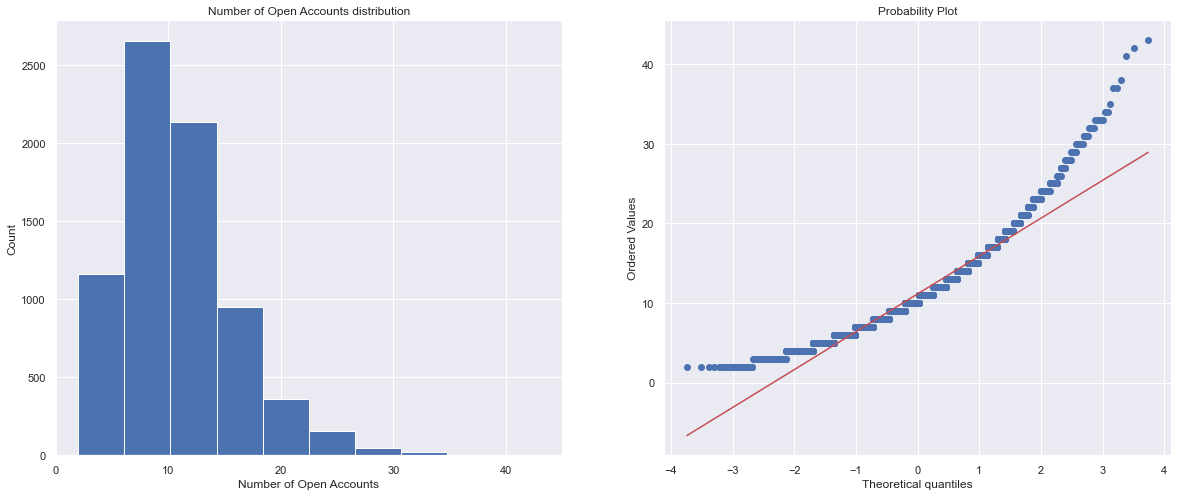

In [42]:
hist_qq('Number of Open Accounts')

In [43]:
df.loc[(df['Number of Open Accounts'] > df['Number of Open Accounts'].quantile(.95)), :].shape

(356, 22)

In [44]:
df.loc[df['Number of Open Accounts'] > df['Number of Open Accounts'].quantile(.95), ['Number of Open Accounts']] =\
            df['Number of Open Accounts'].median()

df_test.loc[df_test['Number of Open Accounts'] > df_test['Number of Open Accounts'].quantile(.95),  \
            ['Number of Open Accounts']] = df_test['Number of Open Accounts'].median()

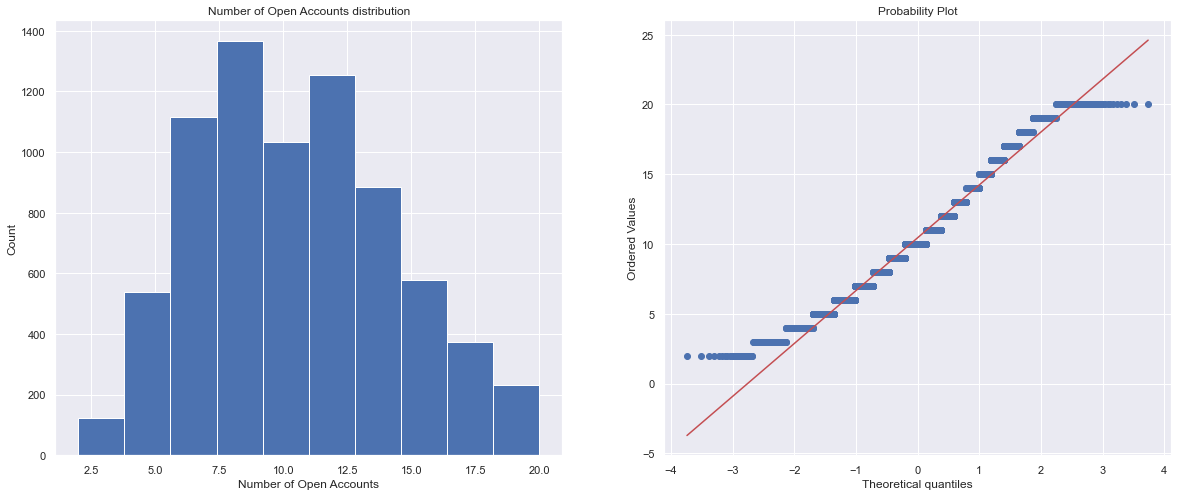

In [45]:
hist_qq('Number of Open Accounts')

### Years of Credit History - коичество лет кредитной истории <a name="6_yoch"></a>

[к оглавлению](#index)

In [46]:
df['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.2      1
4.9       1
39.5      1
42.4      1
39.8      1
Name: Years of Credit History, Length: 408, dtype: int64

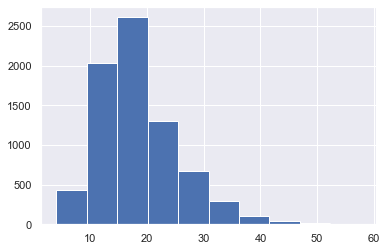

In [47]:
df['Years of Credit History'].hist()

In [48]:
# 40 лет кредитной истории - это уже много
# все, что больше 40 - заменяем на 40

df.loc[df['Years of Credit History'] > 40, ['Years of Credit History']] = 40

df_test.loc[df_test['Years of Credit History'] > 40, ['Years of Credit History']] = 40

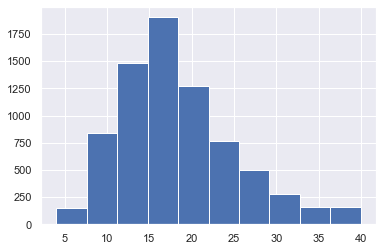

In [49]:
df['Years of Credit History'].hist()

### Maximum Open Credit - наибольший открытый кредит <a name="7_moc"></a>

[к оглавлению](#index)

In [50]:
df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

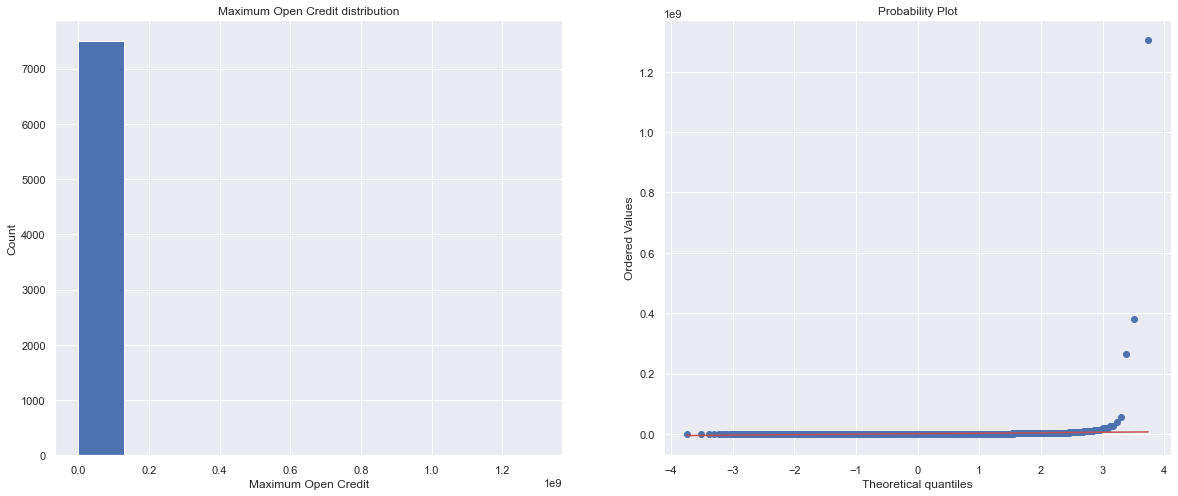

In [51]:
hist_qq('Maximum Open Credit')

In [52]:
# df.loc[(df['Maximum Open Credit'] > df['Maximum Open Credit'].quantile(.95)), :].shape

In [53]:
df.loc[df['Maximum Open Credit'] > df['Maximum Open Credit'].quantile(.95), ['Maximum Open Credit']] =\
            df['Maximum Open Credit'].quantile(.95)

df_test.loc[df_test['Maximum Open Credit'] > df_test['Maximum Open Credit'].quantile(.95), ['Maximum Open Credit']] =\
            df_test['Maximum Open Credit'].quantile(.95)

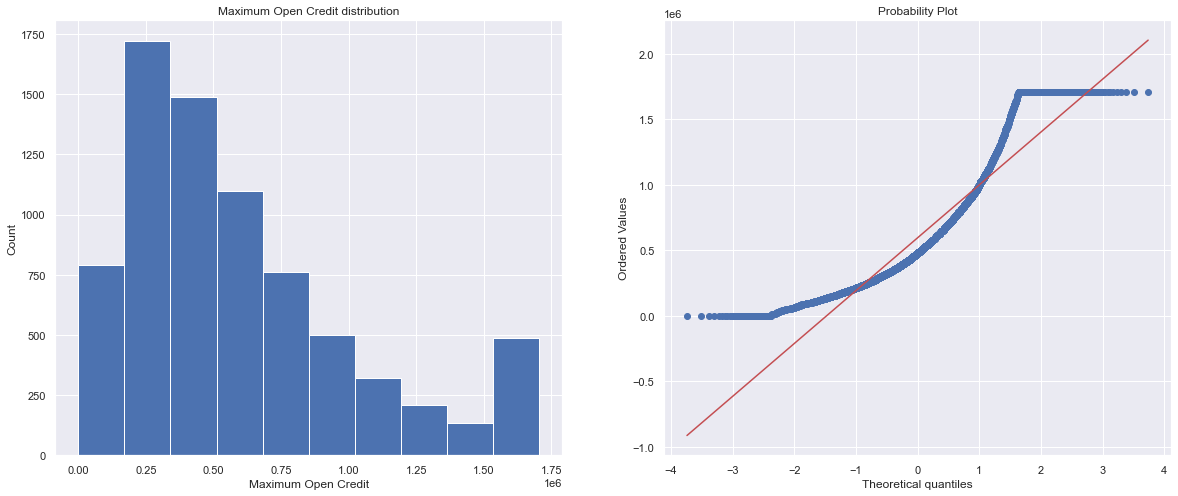

In [54]:
hist_qq('Maximum Open Credit')

### Number of Credit Problems - количество проблем с кредитом <a name="8_nocp"></a>

[к оглавлению](#index)

In [55]:
df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

### Bankruptcies - банкротства <a name=10_b>

[к оглавлению](#index)

In [56]:
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [57]:
df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

### Months since last delinquent - количество месяцев с последней просрочки кредита <a name=9_msld>
    
[к оглавлению](#index)

In [58]:
# df['Months since last delinquent'].describe()

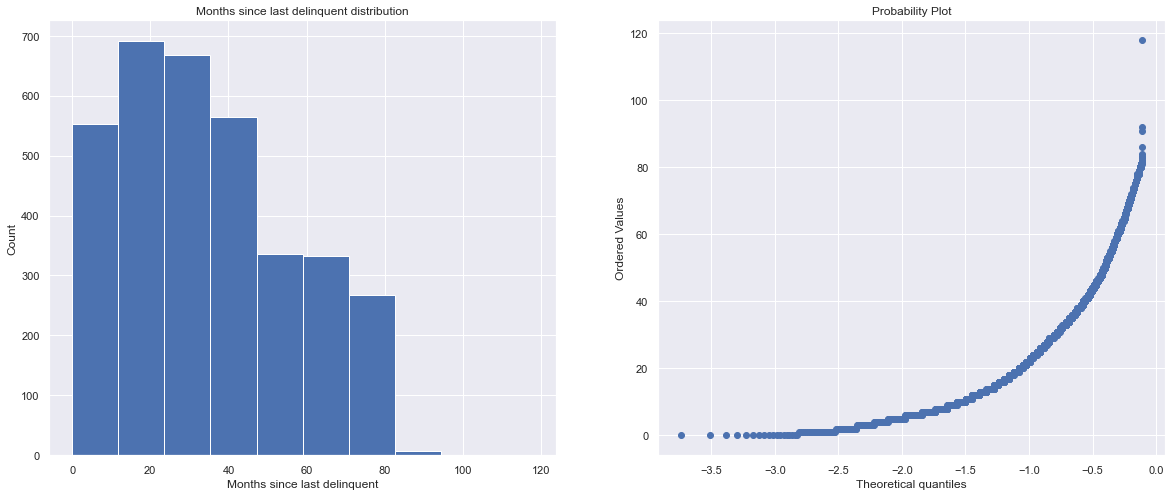

In [59]:
hist_qq('Months since last delinquent')

In [60]:
df['Months since last delinquent NULL'] = df['Months since last delinquent'].isnull()
df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
# df['Months since last delinquent'].fillna(0, inplace=True)

df_test['Months since last delinquent NULL'] = df_test['Months since last delinquent'].isnull()
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0

In [61]:
# # смотрим, как коррелируют признаки с 'Credit Score'

# FEATURE_NAMES = df.columns.drop('Months since last delinquent').tolist()
# corr_Credit_Score = df[FEATURE_NAMES + ['Months since last delinquent']].corr().iloc[:-1, -1]
# corr_Credit_Score = np.abs(corr_Credit_Score).sort_values(ascending=False)

# plt.figure(figsize=(10, 8))

# sns.barplot(x=corr_Credit_Score.values, y=corr_Credit_Score.index)

# plt.title('Correlation')
# plt.show()

In [62]:
# # для обучения выбираем 7 наиболее влияющих признаков (8-й признак сам имеет много null)
# TARGET_FEATURE = list(corr_Credit_Score.index[0:8])

In [63]:
# # отбираем набор данных для обучения
# data = df.loc[(df['Months since last delinquent'].notnull()), TARGET_FEATURE + ['Months since last delinquent']]#.sample(2000)
# data.info()

In [64]:
# %%time

# # учимся по Линейной Регрессии

# model_Credit_Score = LogisticRegression()
# model_Credit_Score.fit(data[TARGET_FEATURE], data['Months since last delinquent'])

In [65]:
# # заполняем в боевом наборе данных пропуски на основе обученной модели

# df.loc[(df['Months since last delinquent'].isnull()), ['Months since last delinquent']] =\
# model_Credit_Score.predict(df.loc[(df['Months since last delinquent'].isnull()), TARGET_FEATURE])

# df_test.loc[(df_test['Months since last delinquent'].isnull()), ['Months since last delinquent']] =\
# model_Credit_Score.predict(df_test.loc[(df_test['Months since last delinquent'].isnull()), TARGET_FEATURE])

In [66]:
# hist_qq('Months since last delinquent')

### Purpose - цель кредита <a name=11_p>

[к оглавлению](#index)

In [67]:
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [68]:
df_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

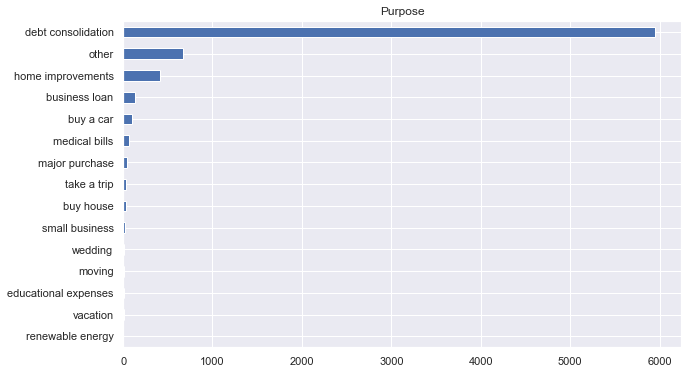

In [69]:
df['Purpose'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Purpose', figsize=(10,6))

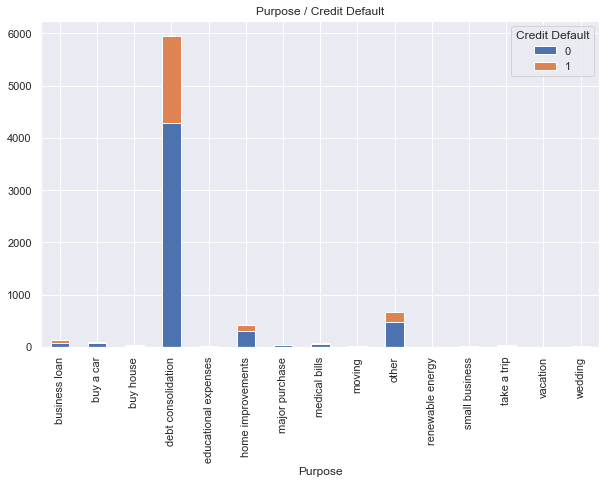

In [70]:
purpose_cr_deafult = df[['Purpose','Credit Default']]
pd.crosstab(purpose_cr_deafult['Purpose'], purpose_cr_deafult['Credit Default']).plot \
(kind='bar', stacked=True, figsize=(10,6), title="Purpose / Credit Default", )

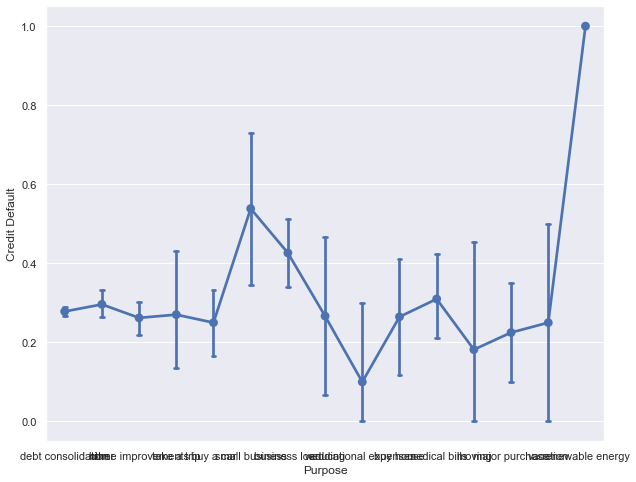

In [71]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='Purpose', y='Credit Default', data=df, capsize=.1,);

In [72]:
# df = pd.concat([df, pd.get_dummies(df['Purpose'], prefix='Purpose')], axis=1)
# df_test = pd.concat([df_test, pd.get_dummies(df_test['Purpose'], prefix='Purpose')], axis=1)

In [73]:
# по графику видно, что можно можно разделить всего на 4 категории

df['Purpose'] = df['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'0',
                                'home improvements':'0',
                                'business loan':'1',
                                'buy a car':'0',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'0',
                                'buy house':'0',
                                'small business':'2',
                                'wedding':'0',
                                'moving':'0',
                                'educational expenses':'3',
                                'vacation':'0',
                                'renewable energy':'0'
                                }).astype(float)

In [74]:
# sns.countplot(x="Purpose", hue='Credit Default', data=df)
# plt.show()

In [75]:
df_test['Purpose'] = df_test['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'0',
                                'home improvements':'0',
                                'business loan':'1',
                                'buy a car':'0',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'0',
                                'buy house':'0',
                                'small business':'2',
                                'wedding':'0',
                                'moving':'0',
                                'educational expenses':'3',
                                'vacation':'0',
                                'renewable energy':'0'
                                }).astype(float)

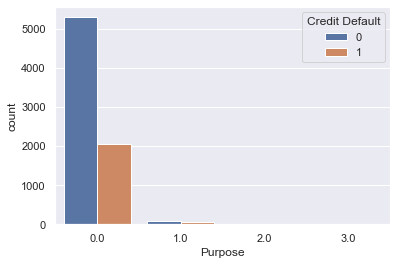

In [76]:
sns.countplot(x="Purpose", hue='Credit Default', data=df)
plt.show()

### Term - срок кредита - срок кредита <a name=12_t>

[к оглавлению](#index)

In [77]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

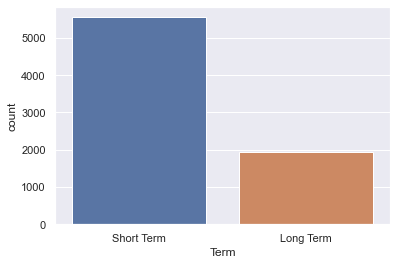

In [78]:
sns.countplot(x="Term", data=df)
plt.show()

In [79]:
df['Term'] = df['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)
df_test['Term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)

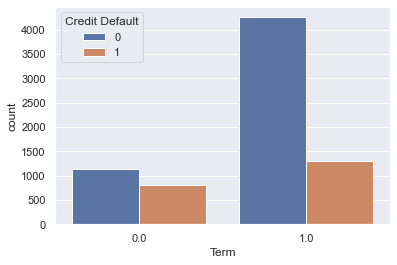

In [80]:
sns.countplot(x="Term", hue='Credit Default', data=df)
plt.show()

In [81]:
corr_('Term',0,1)

1.1519373940439208e-55


### Current Loan Amount - текущая сумма кредита <a name=13_cla>
    
[к оглавлению](#index)

In [82]:
df['Current Loan Amount'].value_counts()
# df['Current Loan Amount BIG'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [83]:
df['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

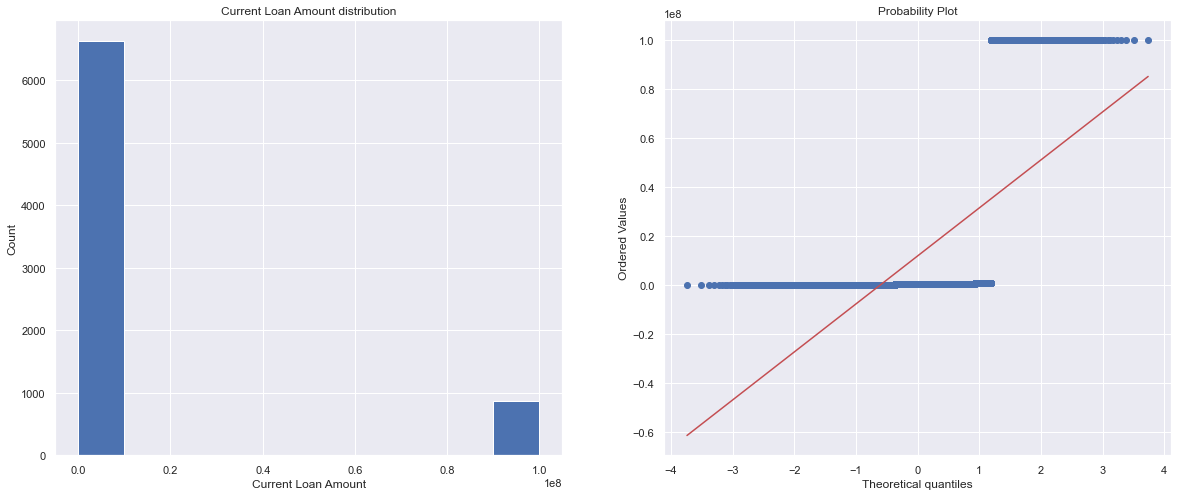

In [84]:
hist_qq('Current Loan Amount')

In [85]:
# вынос больших выбросов в отдельную переменную

df['Current Loan Amount BIG'] = df['Current Loan Amount'] == 99999999
df_test['Current Loan Amount BIG'] = df_test['Current Loan Amount'] == 99999999

In [86]:
df.loc[df['Current Loan Amount'] == 99999999, ['Current Loan Amount']] = None
df_test.loc[df_test['Current Loan Amount'] == 99999999, ['Current Loan Amount']] = None

In [87]:
df.loc[df['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df['Current Loan Amount'].mean() #median()
df_test.loc[df_test['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df_test['Current Loan Amount'].mean() #median()

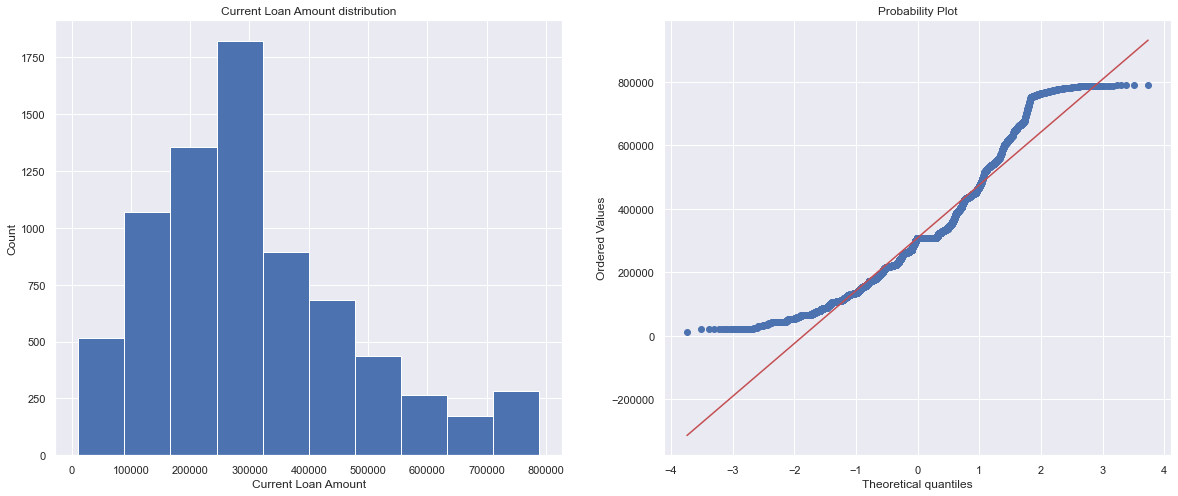

In [88]:
hist_qq('Current Loan Amount')

### Current Credit Balance - текущий кредитный баланс <a name=14_ccb>

[к оглавлению](#index)

In [89]:
df['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

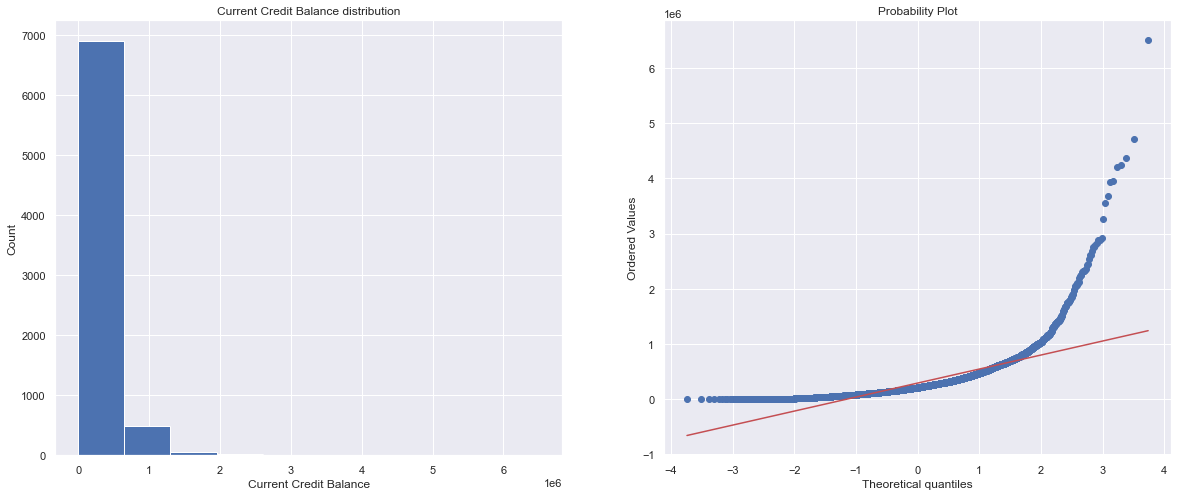

In [90]:
hist_qq('Current Credit Balance')

In [91]:
# выбросы

df.loc[df['Current Credit Balance'] > df['Current Credit Balance'].quantile(.95), :].shape

(375, 24)

In [92]:
df.loc[df['Current Credit Balance'] > df['Current Credit Balance'].quantile(.95), \
       ['Current Credit Balance']] = df['Current Credit Balance'].quantile(.95) #df['Current Credit Balance'].mean()

df_test.loc[df_test['Current Credit Balance'] > df_test['Current Credit Balance'].quantile(.95), \
       ['Current Credit Balance']] = df_test['Current Credit Balance'].quantile(.95) #df_test['Current Credit Balance'].mean()

### Monthly Debt - ежемесячный долг <a name=15_md>

[к оглавлению](#index)

In [93]:
# df['Monthly Debt'].value_counts()

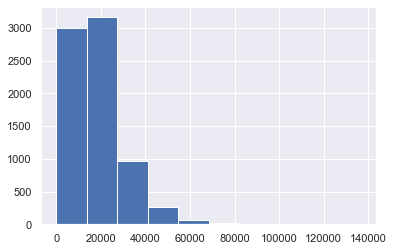

In [94]:
df['Monthly Debt'].hist()

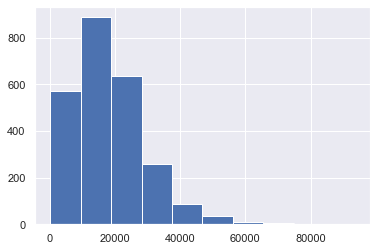

In [95]:
df_test['Monthly Debt'].hist()

In [96]:
df.loc[df['Monthly Debt'] > df['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df['Monthly Debt'].mean()

df_test.loc[df_test['Monthly Debt'] > df_test['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df_test['Monthly Debt'].mean()

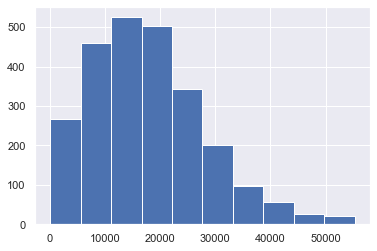

In [97]:
df_test['Monthly Debt'].hist()

### Credit Score - кредитный рейтинг <a name=16_cs>

[к оглавлению](#index)

In [98]:
df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

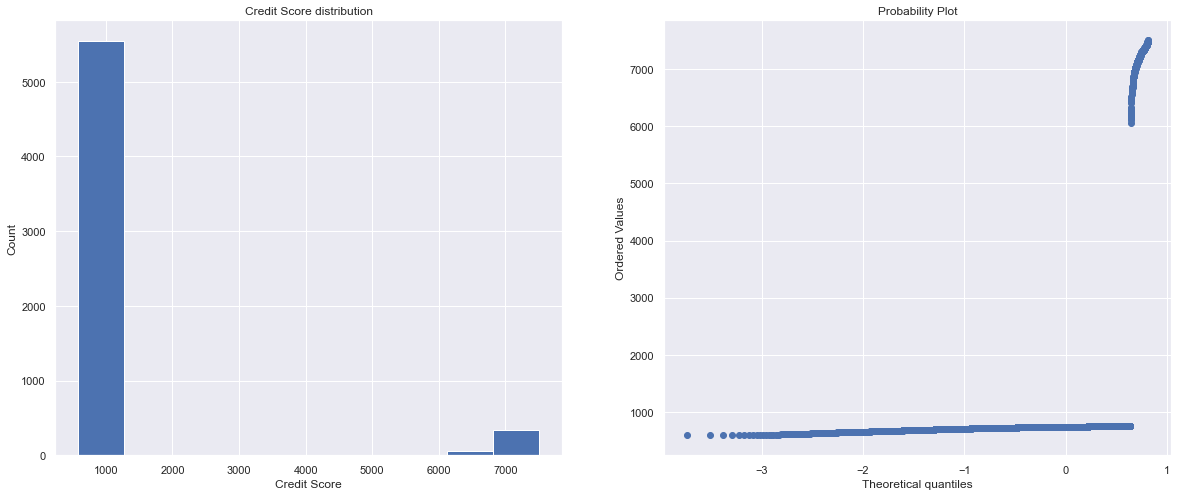

In [99]:
hist_qq('Credit Score')

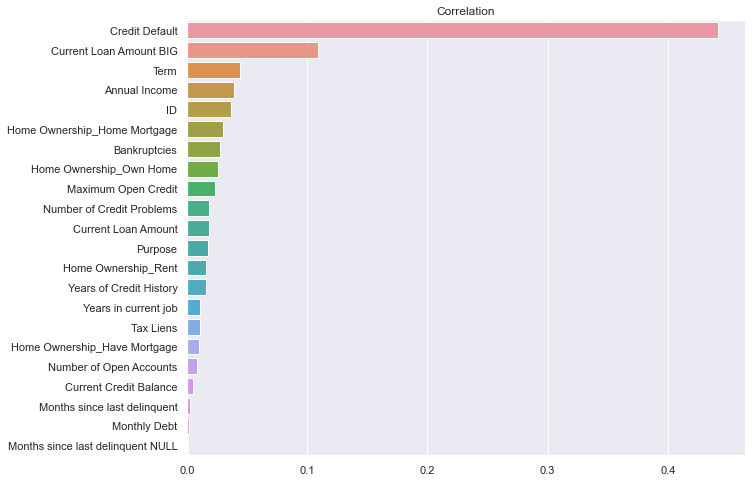

In [100]:
# смотрим, как коррелируют признаки с 'Credit Score'

FEATURE_NAMES = df.columns.drop('Credit Score').tolist()
corr_Credit_Score = df[FEATURE_NAMES + ['Credit Score']].corr().iloc[:-1, -1]
corr_Credit_Score = np.abs(corr_Credit_Score).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Credit_Score.values, y=corr_Credit_Score.index)

plt.title('Correlation')
plt.show()

In [101]:
# для обучения выбираем 7 наиболее влияющих признаков (8-й признак сам имеет много null)
# TARGET_FEATURE = list(corr_Credit_Score.index[0:15])

TARGET_FEATURE = [
#                  'Credit Default',
                 'Current Loan Amount BIG',
                 'Current Loan Amount',
                 'Term',
                 'Annual Income',
#                  'ID',
                 'Home Ownership_Home Mortgage',
                 'Bankruptcies',
                 'Home Ownership_Own Home',
                 'Maximum Open Credit',
                 'Number of Credit Problems',
                 'Purpose',
                 'Home Ownership_Rent',
                 'Years of Credit History',
                 'Years in current job'
                 ]

In [102]:
# отбираем набор данных для обучения
data = df.loc[(df['Credit Score'].notnull()), TARGET_FEATURE + ['Credit Score']]#.sample(2000)
# data

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Current Loan Amount BIG       5943 non-null   bool   
 1   Current Loan Amount           5943 non-null   float64
 2   Term                          5943 non-null   float64
 3   Annual Income                 5943 non-null   float64
 4   Home Ownership_Home Mortgage  5943 non-null   uint8  
 5   Bankruptcies                  5943 non-null   float64
 6   Home Ownership_Own Home       5943 non-null   uint8  
 7   Maximum Open Credit           5943 non-null   float64
 8   Number of Credit Problems     5943 non-null   float64
 9   Purpose                       5943 non-null   float64
 10  Home Ownership_Rent           5943 non-null   uint8  
 11  Years of Credit History       5943 non-null   float64
 12  Years in current job          5943 non-null   float64
 13  Cre

In [104]:
%%time

# учимся на Регрессии

model_Credit_Score = LogisticRegression()
model_Credit_Score.fit(data[TARGET_FEATURE], data['Credit Score'])

Wall time: 16.8 s


LogisticRegression()

In [105]:
# заполняем пропуски на основе обученной модели

df.loc[(df['Credit Score'].isnull()), ['Credit Score']] =\
model_Credit_Score.predict(df.loc[(df['Credit Score'].isnull()), TARGET_FEATURE])

df_test.loc[(df_test['Credit Score'].isnull()), ['Credit Score']] =\
model_Credit_Score.predict(df_test.loc[(df_test['Credit Score'].isnull()), TARGET_FEATURE])

In [106]:
# смотрим, какое распределение получилось
# shapiro(df['Credit Score'])

In [107]:
# hist_qq('Credit Score')

In [108]:
df.loc[(df['Credit Score'] < 700), 'Credit Score'] = 0
df.loc[(df['Credit Score'] >= 700) & (df['Credit Score'] < 740), 'Credit Score'] = 1
# df.loc[(df['Credit Score'] >= 720) & (df['Credit Score'] < 740), 'Credit Score'] = 2
df.loc[(df['Credit Score'] >= 740) & (df['Credit Score'] <= 750), 'Credit Score'] = 2
df.loc[(df['Credit Score'] >= 750) & (df['Credit Score'] <= 800), 'Credit Score'] = 3
df.loc[(df['Credit Score'] > 800), 'Credit Score'] = 4

# df['Credit Score NULL'] = df['Credit Score'].isnull()
# df.loc[df['Credit Score'].isnull(), 'Credit Score'] = 4

# df.loc[df['Credit Score'].isnull(), 'Credit Score'] = df['Credit Score'].median()
# df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = df_test['Credit Score'].median()


df_test.loc[(df_test['Credit Score'] < 700), 'Credit Score'] = 0
df_test.loc[(df_test['Credit Score'] >= 700) & (df_test['Credit Score'] < 740), 'Credit Score'] = 1
df_test.loc[(df_test['Credit Score'] >= 740) & (df_test['Credit Score'] <= 750), 'Credit Score'] = 2
df_test.loc[(df_test['Credit Score'] >= 750) & (df_test['Credit Score'] <= 800), 'Credit Score'] = 3
df_test.loc[(df_test['Credit Score'] > 800), 'Credit Score'] = 4

# df_test['Credit Score NULL'] = df_test['Credit Score'].isnull()
# df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = 4

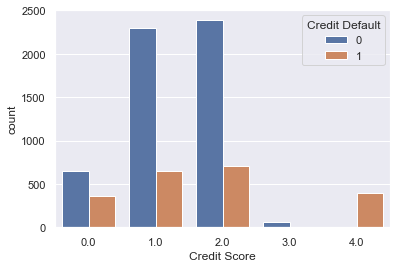

In [109]:
sns.countplot(x="Credit Score", hue='Credit Default', data=df)
plt.show()

## Новый признак <a name="new"></a>

[к оглавлению](#index)

In [110]:
df['No problems'] = (df['Tax Liens'] == 0) & (df['Bankruptcies'] == 0) & (df['Number of Credit Problems'] == 0)
df_test['No problems'] = (df_test['Number of Credit Problems'] == 0) \
                                & (df_test['Bankruptcies'] == 0) & (df_test['Tax Liens'] == 0)

In [111]:
df['No problems'].value_counts()

True     6469
False    1031
Name: No problems, dtype: int64

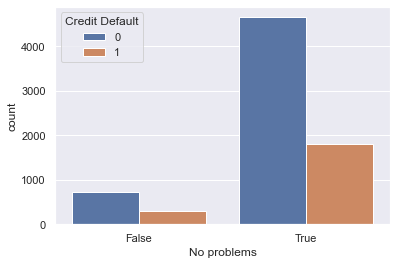

In [112]:
sns.countplot(x="No problems", hue='Credit Default', data=df)
plt.show()

## Обзор целевой переменной. Credit Default <a name=17_cd>

[к оглавлению](#index)

In [113]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

## Смотрим, что получилось <a name=look>

[к оглавлению](#index)

In [114]:
# смотрим train

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Home Ownership                     7500 non-null   object 
 1   Annual Income                      7500 non-null   float64
 2   Years in current job               7500 non-null   float64
 3   Tax Liens                          7500 non-null   float64
 4   Number of Open Accounts            7500 non-null   float64
 5   Years of Credit History            7500 non-null   float64
 6   Maximum Open Credit                7500 non-null   float64
 7   Number of Credit Problems          7500 non-null   float64
 8   Months since last delinquent       7500 non-null   float64
 9   Bankruptcies                       7500 non-null   float64
 10  Purpose                            7500 non-null   float64
 11  Term                               7500 non-null   float

In [115]:
# переделываем Purpose во FLOAT, потому-что некоторые алгоритмы отказываются работать с object

# df['Home Ownership'] = df['Home Ownership'].astype(float)
# df_test['Home Ownership'] = df_test['Home Ownership'].astype(float)

df['Purpose'] = df['Purpose'].astype(float)
df_test['Purpose'] = df_test['Purpose'].astype(float)


In [116]:
# выбираем рабочие столбцы

COL_SELECTED = [
#     'Months since last delinquent NULL',
    'Current Loan Amount BIG',
#     'Credit Score NULL',
    'No problems',
    
#         'Home Ownership', - разделено на dummies
        'Annual Income',
        'Years in current job',
#         'Tax Liens',      - в новый признак
        'Number of Open Accounts',
        'Years of Credit History',
        'Maximum Open Credit',
#         'Number of Credit Problems',      - в новый признак 
#         'Months since last delinquent',
#         'Bankruptcies',      - в новый признак
        'Purpose',
        'Term',
        'Current Loan Amount',
        'Current Credit Balance',
        'Monthly Debt',
        'Credit Score',
    
        'Home Ownership_Have Mortgage',
        'Home Ownership_Home Mortgage',
        'Home Ownership_Own Home',
        'Home Ownership_Rent',
    
#         'Purpose_business loan',
#         'Purpose_buy a car',
#         'Purpose_buy house',
#         'Purpose_debt consolidation',
#         'Purpose_educational expenses',
#         'Purpose_home improvements',
#         'Purpose_major purchase',
#         'Purpose_medical bills',
#         'Purpose_moving',
#         'Purpose_other',
# #         'Purpose_renewable energy', # нет на teste
#         'Purpose_small business',
#         'Purpose_take a trip',
#         'Purpose_vacation',
#         'Purpose_wedding'
                         ]

In [117]:
# выбираем числовые столбцы (чтобы статистику построить)

COL_SELECTED_NUM = [
        'Annual Income',
        'Years in current job',
        'Number of Open Accounts',
        'Years of Credit History',
        'Maximum Open Credit',
        'Current Loan Amount',
        'Current Credit Balance',
        'Monthly Debt',
        'Credit Score',
                         ]

Annual Income
MannwhitneyuResult(statistic=9367790.0, pvalue=0.4769893423833013)


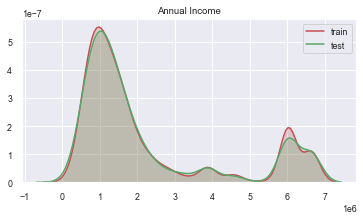

Years in current job
MannwhitneyuResult(statistic=9325493.5, pvalue=0.3434769891811027)


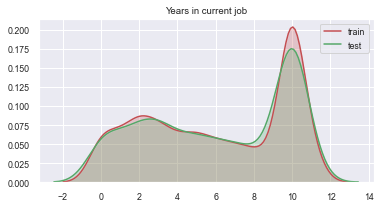

Number of Open Accounts
MannwhitneyuResult(statistic=9268381.0, pvalue=0.19604365761083925)


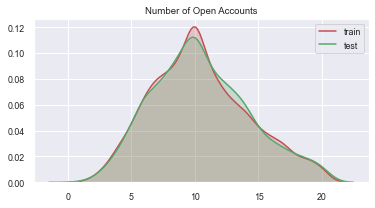

Years of Credit History
MannwhitneyuResult(statistic=9339686.0, pvalue=0.38878036831006235)


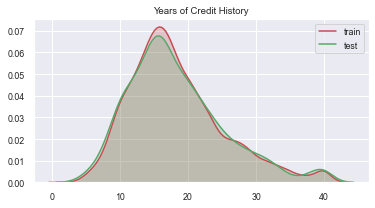

Maximum Open Credit
MannwhitneyuResult(statistic=9314533.5, pvalue=0.31429330558941404)


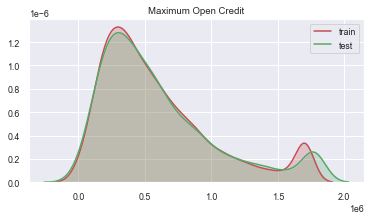

Current Loan Amount
MannwhitneyuResult(statistic=9074421.5, pvalue=0.008078991150053687)


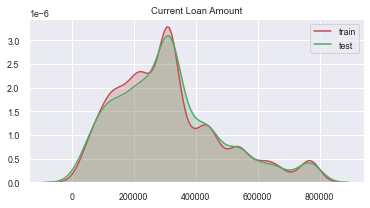

Current Credit Balance
MannwhitneyuResult(statistic=9307269.0, pvalue=0.2939671912978591)


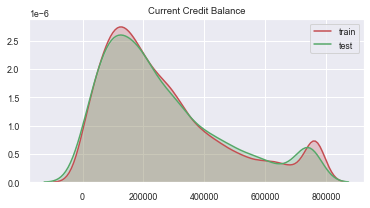

Monthly Debt
MannwhitneyuResult(statistic=9285486.0, pvalue=0.2369733356229915)


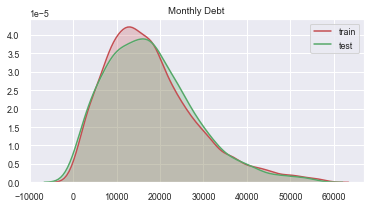

Credit Score
MannwhitneyuResult(statistic=9328862.0, pvalue=0.3460357552111678)


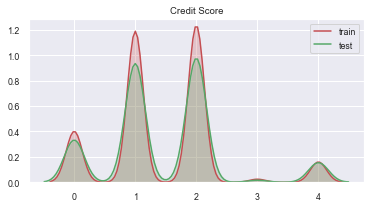

In [118]:
# смотрим похоже-ли распределение непрерывных показателей на train и test

from scipy.stats import mannwhitneyu

# p > 5% - распределения похожи
figsize = (6, 3)
for col in COL_SELECTED_NUM:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

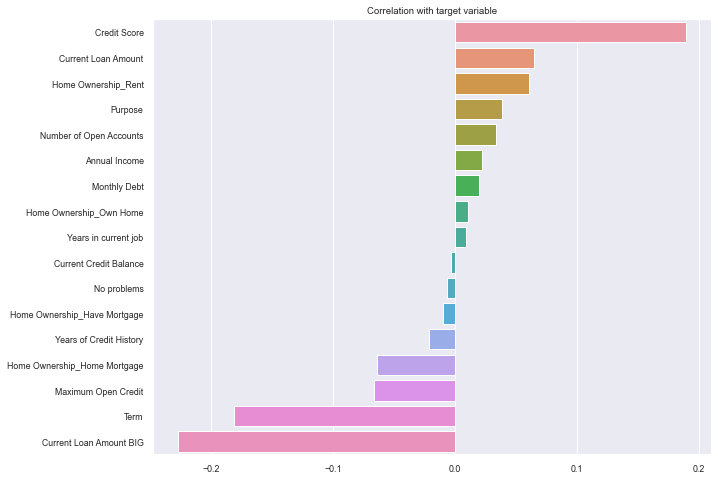

In [119]:
# смотрим влияния столбцов на целевой признак

corr_with_target = df[COL_SELECTED + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

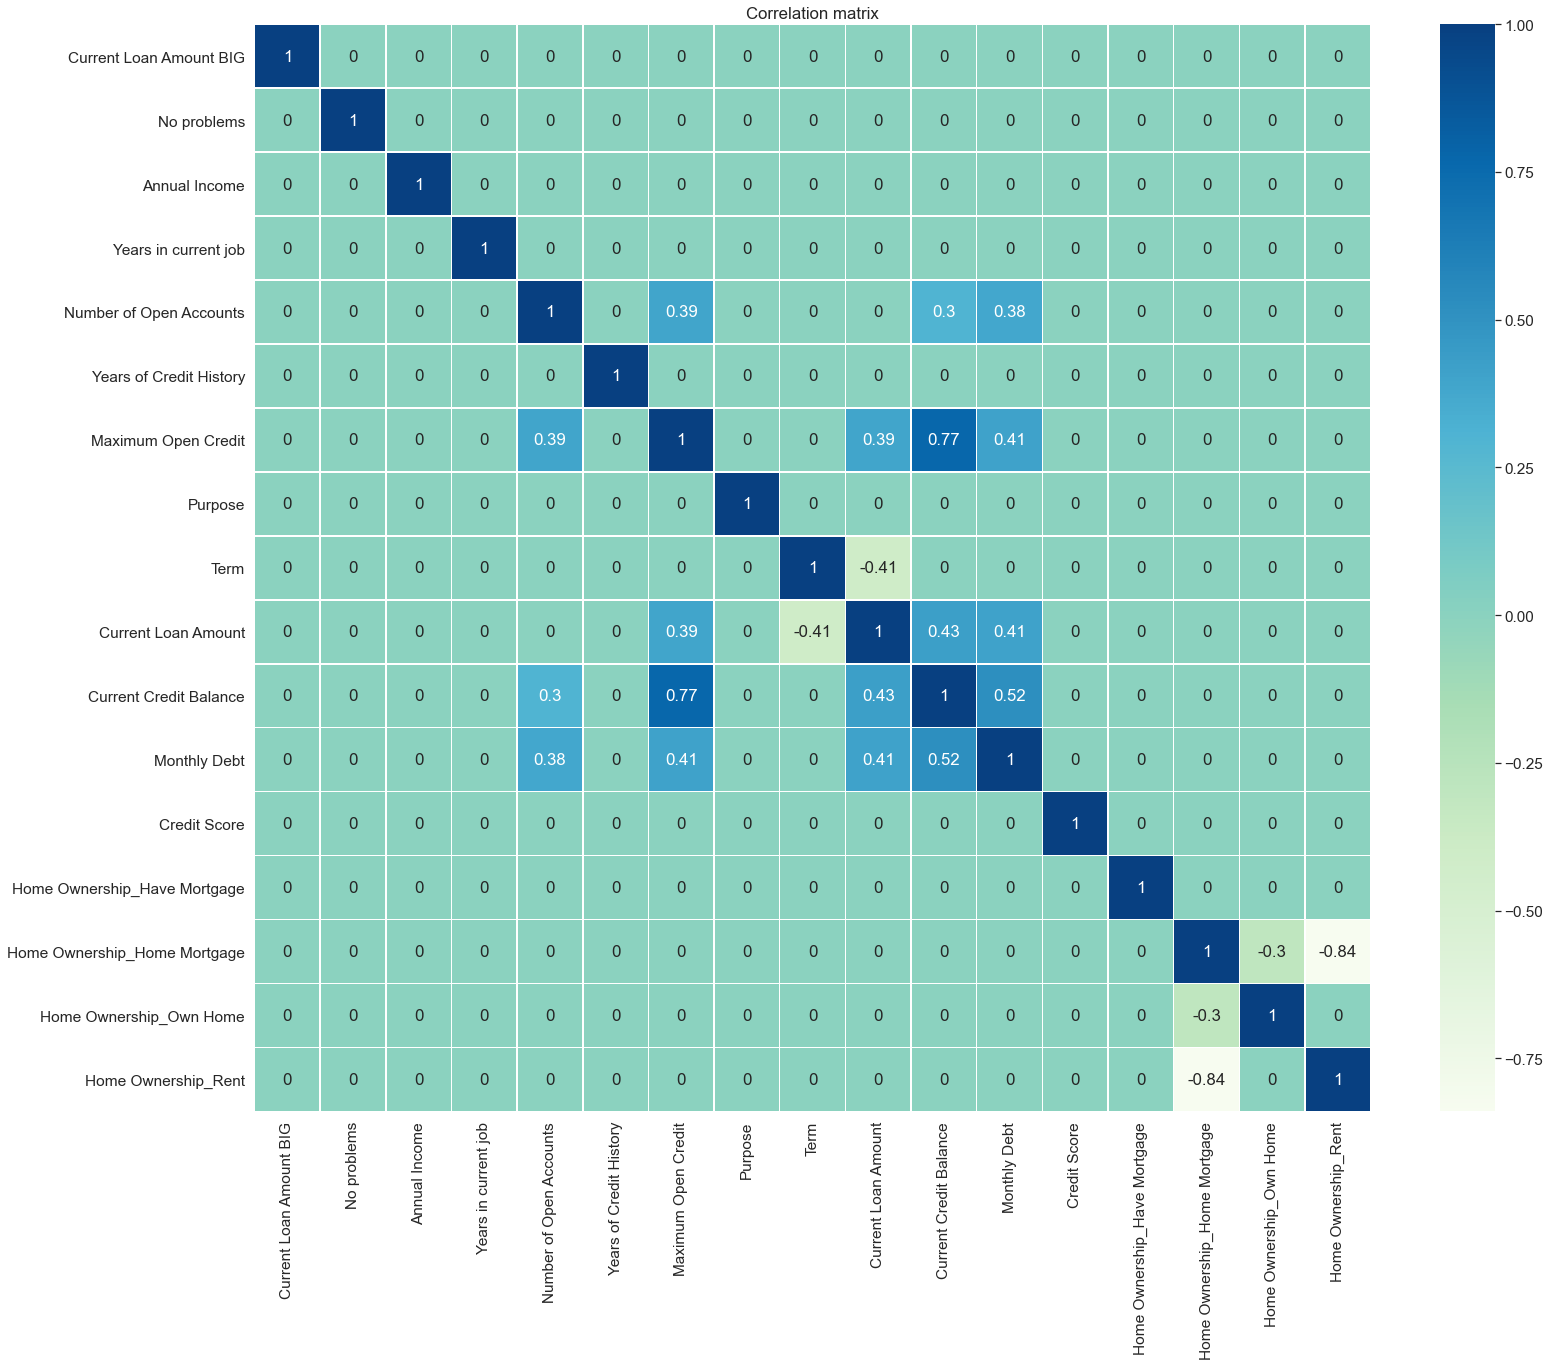

In [120]:
# матрица корреляции

plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df[COL_SELECTED].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

## Нормирование данных <a name=norm>
    
[к оглавлению](#index)

In [121]:
# # нормализация не работает

# scaler = StandardScaler()

# df_norm = df.copy()
# df_norm[COL_SELECTED_NUM] = scaler.fit_transform(df_norm[COL_SELECTED_NUM])

# df = df_norm.copy()

## Разбиение на trein и test. Балансировка целевой переменной. <a name=20_learn>
    
[к оглавлению](#index)

In [122]:
X = df[COL_SELECTED]
y = df['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
#                                                     stratify=y,
                                                    test_size=0.30, 
                                                    random_state=21)

In [123]:
# # смотрим как сбалансирована целевая переменная

# disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
# disbalance

In [124]:
# # Балансировка целевой переменной

# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')
    
# df_balanced['Credit Default'].value_counts()

In [125]:
# X_train = df_balanced.drop(columns='Credit Default')
# y_train = df_balanced['Credit Default']

In [126]:
# # смотрим, что получилось

# disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
# disbalance

## Обучение на моделях <a name=21_learn1>
    
[к оглавлению](#index)

In [127]:
def pred_model(model):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    print(model, '  --  ', f1_score(y_test, y_test_pred))
#     get_classification_report(y_train, y_train_pred, y_test, y_test_pred)    

In [128]:
# cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

for model in [
#             Логистическая регрессия
            LogisticRegression(C = 0.01, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear', max_iter = 50),     
            xgb.XGBClassifier(eval_metric="logloss", max_depth=50, reg_lambda=1, random_state=21),
            KNeighborsClassifier(), # К-ближайших соседей
            BaggingClassifier(), # Беггинг
            RandomForestClassifier(), # Случайный лес    
#             Дерево решений
            DecisionTreeClassifier(random_state=21, class_weight={0:1, 1:3.1}, max_depth=4),
            lgbm.LGBMClassifier(class_weight={0:1, 1:3.1}, random_state=21),
            catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True),
            AdaBoostClassifier(),    
            SVC(C=0.05, kernel='rbf'), # Метод опорных векторов
            GaussianNB(),
            ExtraTreesClassifier(random_state=42, bootstrap=True, min_samples_split=0.3, class_weight='balanced'),
            GradientBoostingClassifier(learning_rate=7, random_state=42), # Бустинг
            Perceptron(class_weight='balanced')    
]:
        pred_model(model)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=50, penalty='l1',
                   solver='liblinear')   --   0.49296636085626916
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=50, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, random_state=21, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)   --   0.44618395303326813
KNeighborsClassifier()   --   0.2405857740585774
BaggingClassifier()   --   0.44000000000000006
RandomForestClassifier()   --   0.42485875706214693
DecisionTreeClassifier(class_weight={0: 1, 1: 3.1}, max_dep

In [129]:
# ансамбль на лучших моделях

model_vote = VotingClassifier(
    estimators=[
#         ('Logistic Regression', 
#                  LogisticRegression(C = 5, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear', max_iter = 50)),
#         ('XGBoost', xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=21)),
#         ('K-Neighbours', KNeighborsClassifier()),
#         ('DecisionTree', DecisionTreeClassifier(random_state=21,
#                                     class_weight={0:1, 1:3.6},
#                                     max_depth=4
#                                     )),
        ('LightGBM', lgbm.LGBMClassifier(class_weight={0:1, 1:3.3}, random_state=21)),
        ('CatBooster', 
                            catb.CatBoostClassifier(class_weights=[1, 3.3], 
                                    depth=3,
                                    iterations=400,
#                                     l2_leaf_reg=300,
#                                     cat_features=CAT_FEATURE_NAMES,
                                    silent=True, 
#                                     early_stopping_rounds=20, #  изменения тут на результат не влияют
#                                     use_best_model=True,
#                                     random_state=21
                                    )),
#         ('Ada Boost', AdaBoostClassifier()),
#         ('SVM', SVC()),
#         ('Naive Bayes', GaussianNB()),
        ('Extra Tree', 
                ExtraTreesClassifier(random_state=42, bootstrap=True, min_samples_split=0.3, class_weight='balanced')),
#         ('Gradient Boosting', GradientBoostingClassifier(learning_rate=7, random_state=42)),
#         ('Perceptron', Perceptron(class_weight='balanced'))
    ],
    voting='hard',
    n_jobs=-1)

model_vote.fit(X_train, y_train)

y_train_pred = model_vote.predict(X_train)
y_test_pred = model_vote.predict(X_test)

print('VOTE:: ')
print(f1_score(y_test, y_test_pred))
# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

VOTE:: 
0.5371900826446281


In [130]:
# отдельно модель CatBoost

model_catb = catb.CatBoostClassifier(class_weights=[1, 3.3],
                                    depth=3,
                                    iterations=400, 
#                                     l2_leaf_reg=300,
#                                     cat_features=CAT_FEATURE_NAMES,
                                    silent=True, 
#                                     early_stopping_rounds=20, #  изменения тут на результат не влияют
#                                     use_best_model=True,
#                                     random_state=21
                                    )

model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

print('CatBoost:: ')
print(f1_score(y_test, y_test_pred))
# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

CatBoost:: 
0.541019955654102


In [134]:
# # # сохраняем результат

# df_test["Credit Default"] = model_vote.predict(df_test[COL_SELECTED])
df_test["Credit Default"] = model_catb.predict(df_test[COL_SELECTED])


df_test['ID'] = df_test.index.tolist()
df_test['ID'] = df_test['ID']
df_test1 = df_test[['Credit Default', 'ID']]
# df_test1.to_csv(r'__Vote_27_4_.csv', index=False)
df_test1.to_csv(r'___Cat_27_44_.csv', index=False)

* baseline - catb = .5547 // **.5488**, vote = .5475 // **.55493**

**Урок 3. Теория**

1. Для чего и в каких случаях полезны различные варианты усреднения для метрик качества классификации: micro, macro, weighted?

micro - это по-сути **accuracy**

macro - простое среднее (не уитывает дисбаланс классов)

weighted - рассчитывает среднее **с учетом дисбалланса классов**

2. В чём разница между моделями xgboost, lightgbm и catboost или какие их основные особенности?

Основные отличия в том, как строятся деревья, как объединяются фичи и в скорости работы (lightgbm - самая быстрая, catboost - самая медленная)

**Урок 2. Теория**

1. В чём различие между зависимыми и независимыми выборками?

В зависимых выборках изменения в одной выборке как-то влияют на изменения в другой выборке.<br>
В независимых выборках изменения в одной выборке вообще никак не влияет на другую выборку.

2. Когда применяются параметрические статистические критерии, а когда — их непараметрические аналоги?

Параметрические критерии: нормальное распределение, достаточный объем выборки, количественная информация (числа)
Непараметрические критерии: распределение отличное от нормального, малый объем выборки, может быть неколичественная информация

**Домашка 1. Теоретический вопросы.**

1. Приведите по 2 примера, когда лучше максимизировать Precision, а когда Recall.

Precision (точность): используется, когда важно не ошибиться при обнаружении искомых объектов. Примеры: `1- обнаружение магазинных воришек` (важно не только найти воришек, но и не обвинить невиновных) или `2- диагностика тяжелых, но трудно диагностируемых заболеваний`.
Т.е. мы должны быть уверенны, когда относим что-то к искомому классу.

Recall (полнота): использутеся, когда нам важно найти максимальное количество объектов искомого класса. Примеры: `1- обнаружение нарушителей на КПП важного объекта` или `2- обнаружение террористов`. 
Т.е. можно позволить себе ошибаться, главное - не пропустить виновных.

2. Почему мы используем F-меру, почему, например, нельзя просто взять среднее от Precision и Recall?

`F-мера это гармоническое среднее. Т.е. по сути это тоже среднее, но с возможностью регулировать величину значения вкладв в этот показатель Точности и Посноты при такой необходимости. `